# Analysis of WASP-189 (Transit: Visit 1) using `pycheops`

In the following notebook, we will analyse the data from `CHEOPS` visit 1 data of HD106315b using `pycheops`.

The method is similar to that used in the analysis of KELT-11b data ([https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb](https://github.com/Jayshil/pycheops-tutorials/blob/main/KELT-11/p2_kelt11_extra_decorr_parm.ipynb)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import UFloat
from uncertainties.umath import sqrt as usqrt
import re
from pycheops.utils import phaser
from pycheops.models import TransitModel, FactorModel, EclipseModel
import astropy.units as u
from lmfit import minimize as mz
from pycheops.constants import c, au

## Downloading the data

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR100036_TG000701_V0200.tgz
 PI name     : Brice-Olivier DEMORY
 OBS ID      : 1145201
 Target      : WASP-189
 Coordinates : 15:02:44.87 -03:01:53.0
 Spec. type  : A6V
 G magnitude : 6.55 +- 0.00
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR100036_TG000701_V0200-DEFAULT.fits
Time stored relative to BJD = 2459016
Aperture radius used = 25 arcsec
UTC start:  2020-06-15T18:07:40
UTC end:    2020-06-18T21:07:01
Visit duration: 269961 s
Exposure time: 7 x 4.8 s
Number of non-flagged data points: 4758
Efficiency (non-flagged data): 59.2 %
Light curve corrected for flux from background stars
Mean counts = 140556171.2
Median counts = 140629390.3
RMS counts = 222219.7 [1580 ppm]
Median standard error = 11901.2 [85 ppm]
Median background = 262452 e-/pxl
Mean contamination = 733.0 ppm
Mean smearing correction = 60.4 ppm

Rejected 12 points more than 5.0 x MAD = 356 ppm from the median


/home/jayshil/anaconda3/lib/python3.8/site-packages/pycheops-0.9.16-py3.8.egg/pycheops/dataset.py:426: UserWarning: No metadata in file /home/jayshil/.local/share/pycheops/CH_PR100036_TG000701_V0200.tgz
  warnings.warn(msg)


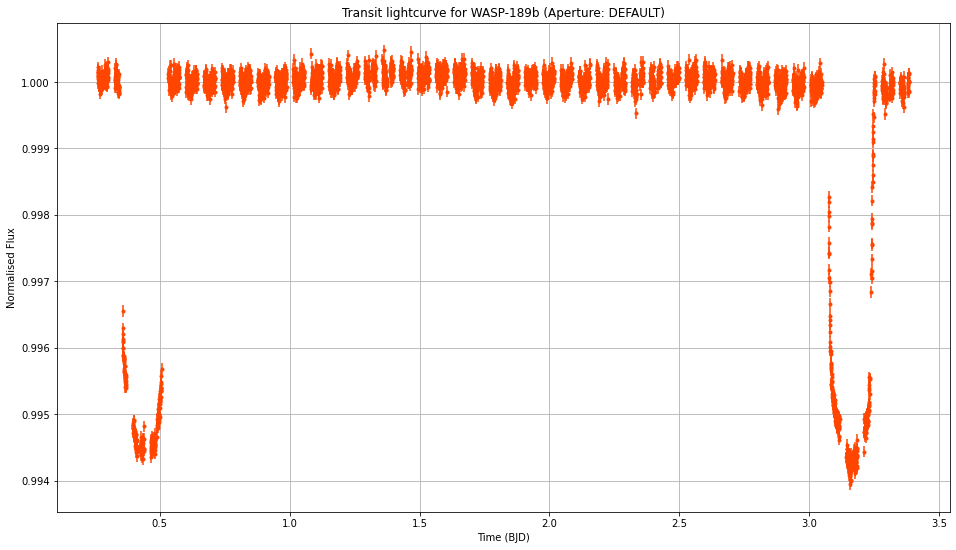

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR100036_TG000701_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='DEFAULT', decontaminate=True)#, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
tim, fl, fle = dd.clip_outliers(verbose=True);

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for WASP-189b (Aperture: DEFAULT)')
plt.grid()

### Planetary check

We may want to check the position of various planetary bodies with respect to the target star, because if some of the bodies is very near to the target star then we may want to correct for their effects.

In [3]:
dd.planet_check()

BJD = 2459016.260447496
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     01:28:57.05  +04:05:47.0      42.4
Mars     23:35:07.42  -05:41:00.0      82.0
Jupiter  19:49:36.55  -21:18:28.3      66.3
Saturn   20:11:47.02  -20:10:17.7      73.7
Uranus   02:26:57.74  +14:03:48.3     165.0
Neptune  23:27:22.67  -04:40:49.8     123.8


## Stellar and Planetary properties

A knowledge of the stellar and planetary property of the system under investigation can proved to be useful while analysing the system. We can use some of the properties as priors in our analysis. In `pycheops` there are some in-build tools  available which ca go through the available stellar and planetary catalogues (like SWEET-Cat, or DACE) to give us the properties. Below, we show how to access such properties.

In [4]:
# For planetary properties
# This cell is copied from pycheops examples notebook
# The planet properties will not provide good results
# Hence, we will use ExoCTK to get planetary parameters.
"""
try: 
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=True)
except:
    hd106315b = pycheops.PlanetProperties('HD 106315b',query_dace=False, query_tepcat=False,
                                    depth = ufloat(298.909, 20.791),   # PPM
                                    width = ufloat(0.1572,0.0034),  # days (that means that is transit duration -- in days)
                                    ecosw=0.,#ufloat(-0.0040, 0.0490), 
                                    esinw=0.,#ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2457586.5487, 0.0029),
                                    P = ufloat(9.55237, 0.00089))
    
print(hd106315b)
"""
# Using ExoCTK to get planetary properties
rprs = np.random.normal(0.060907361661750425, 0.003144594526637345, 10000)
dep, dep_err = np.mean((rprs**2)*1e6), np.std((rprs**2)*1e6)

Well..., apparently, I cannot (even after studying two semesters at Geneva) access DACE-Planets. No problem --- we have TEPCat at our service. We derived parameters from there. We can now try searching for the host star.

In [5]:
"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(8000, 80, 10000)
logg = np.random.normal(3.9, 0.2, 10000)
mh = np.random.normal(0.29, 0.13, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])

It seems that the program would return nan to h1 and h2 because the temperature is out of range of the grid. So, we will let free the h1 and h2 in the analysis.

We have it! Here `h_1` and `h_2` are power2 law limb darkening coefficients.

## Renormalising the lightcurve

It already seems pretty flatten -- and applying the function would only reduce the quality of the data.

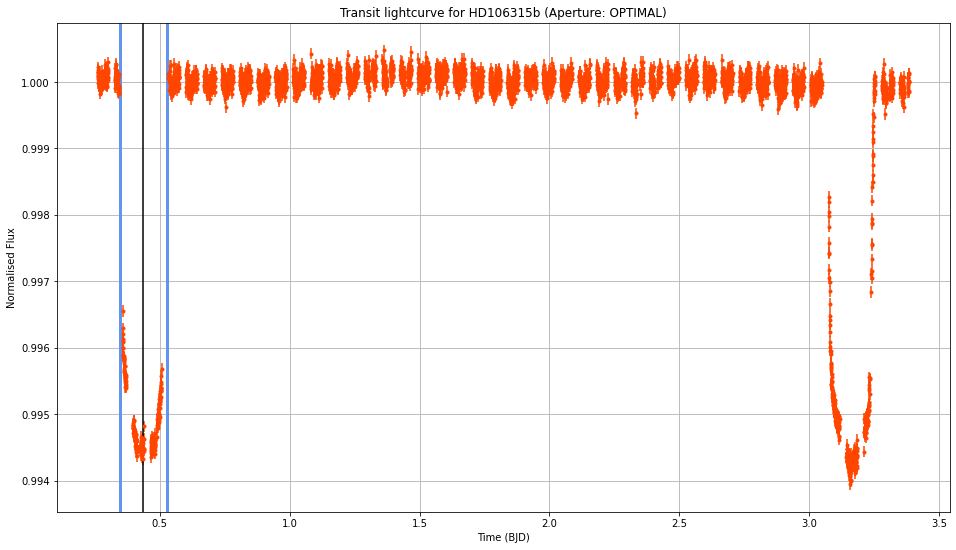

In [6]:
# This code is taken from the pycheops example notebook
P = 2.7240338
BJD_0 = 2456706.4558
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + (cycle+0)*P

D = dep/1e6  # Depth stored in ppm
W = 0.1819/P    # Width stored in days
a_c = 0.05053 * au/c / 86400

try:
    f_c = 0.#np.sqrt(0.093)*np.sin(67.0*np.pi/180)
    f_s = 0.#np.sqrt(0.093)*np.cos(67.0*np.pi/180)
except:
    # From Pepper et al., 2017
    ecosw = 0.#ufloat(-0.004,0.05099)
    esinw = 0.#ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = 0.#esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = 0.#ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


#tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(T_0, c='k')
plt.axvline(x=T_0-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_0+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for HD106315b (Aperture: OPTIMAL)')
plt.grid()

## Detrending (or, decorrelating) the dataset

To perform this operation of detrending we may want to look at diagnostic report for this observations. The diagnostic report consist of various plots of flux as a function of several instrumental properties like roll angle of the spacecraft, centroid position etc. This would enable us to see if there is any trend going on with instruments so that we can take care of it. So, first let's see the diagnostic report...

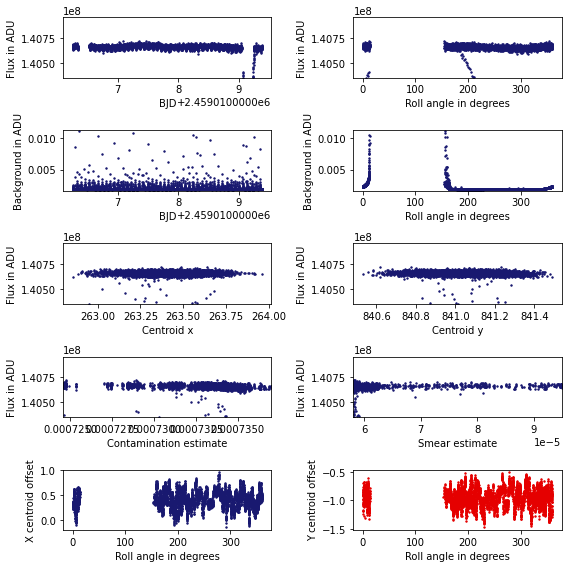

In [7]:
dd.diagnostic_plot()

### Performing decorrelation

We can see above that, `Dataset.should_I_decorr` function suggests that several decorrelations should be done. Various parameters shows different correlations with different properties of the instrument. From $\texttt{pycheops-cookbook}$ I mention where each of these parameters belong:

- flux versus time: $\texttt{dfdt}$, $\texttt{d2fdt2}$
- flux versus x-centroid: $\texttt{dfdx}$, $\texttt{d2fdx2}$
- flux versus y-centroid: $\texttt{dfdy}$, $\texttt{d2fdy2}$
- flux versus roll angle: $\texttt{dfdsinphi}$, $\texttt{dfdcosphi}$, $\texttt{dfdsin2phi}$, $\texttt{dfdcos2phi}$, $\texttt{dfdsin3phi}$, $\texttt{dfdcos3phi}$
- flux versus background: $\texttt{dfdbg}$
- flux versus contamination: $\texttt{dfdcontam}$
- flux versus smear: $\texttt{dfdsmear}$

Note that not each of the parameters have same units (especially $\texttt{dfdt}$), therefore, one may want to take care while defining these parameters in analysis.

There are (I think) two ways to take care of these correlations --- we can either use `dataset.decorr` function to take care of these correlations, or we can do it in the later stage of fitting the data. There is a little advantage of doing this in a later stage of curve fitting: if we do at that point, we can see the effect of <i>adding</i> parameters to the fitting with Bayes' factors. We can even neglect additional parameters which are not supported by the data.

Below, we try to include one by one parameter in the model and see its effect on the fitting in form of the Bayes' factor. However, before including decorrelation parameters, we fit <i>without</i> any decorrelation parameters. We can use results from this fitting as priors for the modelling which includes decorrelation parameters.

In [8]:
# Let's first do this without correlation;
# and if needed we can try decorrelating using dataset.decorr

In [20]:
# This is the function that we will minimize in order to fit the model
def _chisq_prior(pars, *args):
    r = (fl - Model.eval(pars, t = tim))/fle
    for p in pars:
        u = pars[p].user_data
        if isinstance(u, UFloat):
            r = np.append(r, (u.n - pars[p].value)/u.s)
    return r

## Let's make the model

In [23]:
# The model (transit and eclipse)
Model = FactorModel() * TransitModel(prefix = "T_") * EclipseModel()

# Let's add parameters
pars = Model.make_params()
pars.add("P", value = 2.7240338, vary=False)
pars.add("T_0", value = 0.4352999, vary=False)
pars.add("D", value = 0.004901001, min = 0.004901001/4, max = 0.004901001*4)
pars.add("logrhoprior", value = 0.15455986, vary=False)
pars.add("W", value = 0.06517213, min = 0.06517213/4, max = 0.06517213*4)
pars.add("b", value = 0.5, min = 0., max = 1.)
pars.add("f_c", value = 0., vary=False)
pars.add("f_s", value = 0., vary=False)
pars.add("T_h_1", value = 0.787, vary=False)
pars.add("T_h_2", value = 0.529, vary=False)
pars.add("L", value = 2e-4, min = 1e-6, max = 1e-3)
pars.add("a_c", value = a_c, vary=False)

for parameters in ["P", "T_0", "D", "W", "b", "f_c", "f_s", "c"]:
    pars.add("T_".format(parameters), expr = parameters)

In [24]:
result = mz(_chisq_prior, pars, nan_policy = 'propagate', args = (Model, tim, fl, fle))

flux_model = Model.eval(result.params, t = tim)
residuals = result.residual

/home/jayshil/anaconda3/lib/python3.8/site-packages/pycheops-0.9.16-py3.8.egg/pycheops/funcs.py:363: RuntimeWarning: invalid value encountered in cos
  z = np.sqrt(1 - np.cos(nu)**2*sini**2)/rstar
/home/jayshil/anaconda3/lib/python3.8/site-packages/pycheops-0.9.16-py3.8.egg/pycheops/funcs.py:379: RuntimeWarning: invalid value encountered in sin
  return z, np.sin(nu + omrad)*sini < 0


In [25]:
result.params

name,value,initial value,min,max,vary,expression
c,0.99944162,1.0,0.00000000,inf,True,
dfdt,0.00000000,0,-inf,inf,False,
d2fdt2,0.00000000,0,-inf,inf,False,
dfdbg,0.00000000,0,-inf,inf,False,
dfdcontam,0.00000000,0,-inf,inf,False,
dfdsmear,0.00000000,0,-inf,inf,False,
ramp,0.00000000,0,-inf,inf,False,
dfdx,0.00000000,0,-inf,inf,False,
dfdy,0.00000000,0,-inf,inf,False,
d2fdxdy,0.00000000,0,-inf,inf,False,


Text(0, 0.5, 'Residuals')

<Figure size 1152x648 with 0 Axes>

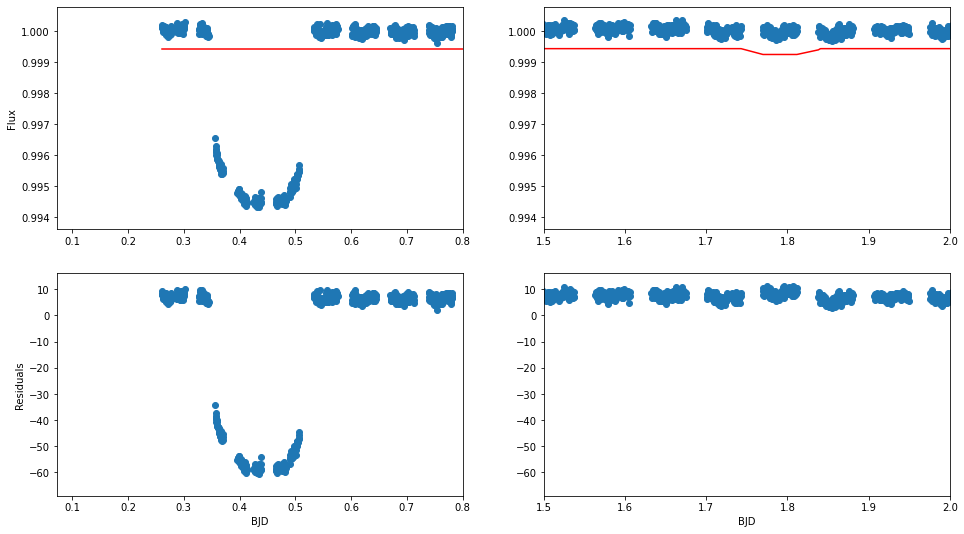

In [26]:
# Let's plot it!!
N_plots = 2
figure = plt.figure(figsize=(16,9))
figure, ax = plt.subplots(ncols = N_plots, nrows = N_plots, figsize=(16,9))

for i in range(N_plots):
    ax[0][i].scatter(tim, fl)
    ax[0][i].plot(tim, flux_model, "r")

for j in range(N_plots):
    ax[1][j].scatter(tim, residuals)
    ax[1][j].set_xlabel("BJD")

for k in range(N_plots):
    ax[k][0].set_xlim(T_0 - 2 * P * W, T_0 + 2 * P * W)

for l in range(N_plots):
    ax[l][1].set_xlim(1.5,2.0)

ax[0][0].set_ylabel("Flux")
ax[1][0].set_ylabel("Residuals")
#print(result.fit_report())